# Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [179]:
%autoreload

import numpy as np
import pickle

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

import main

import darkhistory.physics as phys
import darkhistory.utilities as utils

from darkhistory.spec import spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
from darkhistory.low_energy import lowE_electrons
from darkhistory.low_energy import lowE_deposition

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm


In [76]:
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/'

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



In [77]:
ics_thomson_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "rb")) 
ics_rel_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "rb"))

Load the standard ionization and thermal histories.

In [102]:
soln = pickle.load(open("/Users/hongwan/Github/DarkHistory/darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
Tm_std = interp1d(soln[0,:], soln[1,:])

# Load Reference Files

## Load Reference Spectra

Load the file containing the reference spectra.

In [106]:
hdul = fits.open(
    '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/tf_z_3.000E+03_nstep_6622_logE_1.230E+01_xe_0.000E+00.fits'
)
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

hdul.close()

## Load Reference $f(z)$ (Direct from IDL)

Load the file containing the $f(z)$ calculations

In [167]:
hdul = fits.open(
    '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/calculated_fractions_phot_logE_1.230E+01.fits'
)
data = hdul[1].data

f_idl_low  = data.field('loweng_deposition_fractions')[0]
f_idl_high = data.field('higheng_deposition_fractions')[0]

f_idl = f_idl_low + f_idl_high

print(f_idl.shape)

hdul.close()

(5, 6622)


## Load Reference $f(z)$ (from Mathematica)

Load the $f(z)$ values from Mathematica.

In [173]:
direc = '/Users/hongwan/Dropbox (MIT)/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}

In [174]:
log10f_tmp = log10f_phot_decay

def f_H_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_He_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['He_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_H_exc(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_exc'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_heating(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['heating'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_cont(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['cont'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

# `DarkHistory` Evaluation, $m_\chi = 2 \times 10^{12}$ eV, $\chi \to \gamma \gamma$

In [91]:
eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

# Due to configuration issues, specifying mwimp=2e12 with tau = 1e25
# in the main code actually translates into an *actual* mDM=4e12, with
# tau = 0.5e25.
mDM = 4e12
tau = 0.5e25

# kinetic energy!
# elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - 2*phys.me)/2]), eleceng)
# elec_spec_init.rs = 3000

# phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

# find the uppermost bin to perform the injection.
# inject mDM/2/eng_delta_inj particles.
injE = photeng[photeng < mDM/2][-1]

phot_spec_init = spectools.rebin_N_arr(np.array([2*mDM/2/injE]), np.array([injE]), photeng)
phot_spec_init.rs = 3000

elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

b_4e12 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 4,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp, ics_only=False,
    ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf,
    coarsen_factor=1,std_soln=True, user=None, verbose=False, use_tqdm=True
)



AHHHH YEAHHHH!


# $f(z)$ Calculation Comparisons - PASSED

## `DarkHistory` Calculation

First, we will compare the $f(z)$ computed by `DarkHistory` with the values obtained by Tracy, using the same spectral input from the IDL produced reference file, but running `lowE_deposition.compute_fs` to obtain the corresponding values of $f(z)$. 

In [180]:
# Create the MEDEA interpolation object
MEDEA_interp = lowE_electrons.make_interpolator()

AHHHH YEAHHHH!


In [181]:
# Vector of dt steps.
rs_vec = b_4e12[2].rs
dt_vec = 0.001/phys.hubble(rs_vec)
std_xe_vec = xe_std(rs_vec)

# Store x_input in the correct format
x_input = np.transpose([1-std_xe_vec, np.zeros_like(std_xe_vec), np.zeros_like(std_xe_vec)])

# Calculate rate_input for input to compute_fs
rate_input = rate_func_eng(rs_vec)

# Convert the IDL spectra to Spectra objects.
ref_lowengelec = Spectra(idl_lowengelec*idl_elec_bin_width, eng=idl_eleceng, rs=rs_vec, spec_type='N')
ref_lowengphot = Spectra(idl_lowengphot*idl_bin_width, eng=idl_energy, rs=rs_vec, spec_type='N')

# Empty container for f's
f_arr_DH = np.outer(np.zeros_like(rs_vec),np.zeros(5))

# Loop compute_fs over the spectra produced.
for i, (elec_spec, phot_spec, x, dE_dVdt_inj, dt, highengdep, cmbloss) in tqdm(
    enumerate(
        zip(
            ref_lowengelec, ref_lowengphot, x_input, rate_input, dt_vec, 
            np.transpose(idl_highengdep), idl_cmblosstable
        )
    ),   
    total = idl_cmblosstable.shape[0] # Just for tqdm
) :
    f_arr_DH[i] = lowE_deposition.compute_fs(
        MEDEA_interp, elec_spec, phot_spec, x, dE_dVdt_inj, dt, highengdep, cmbloss, method="old"
    )

## Plots

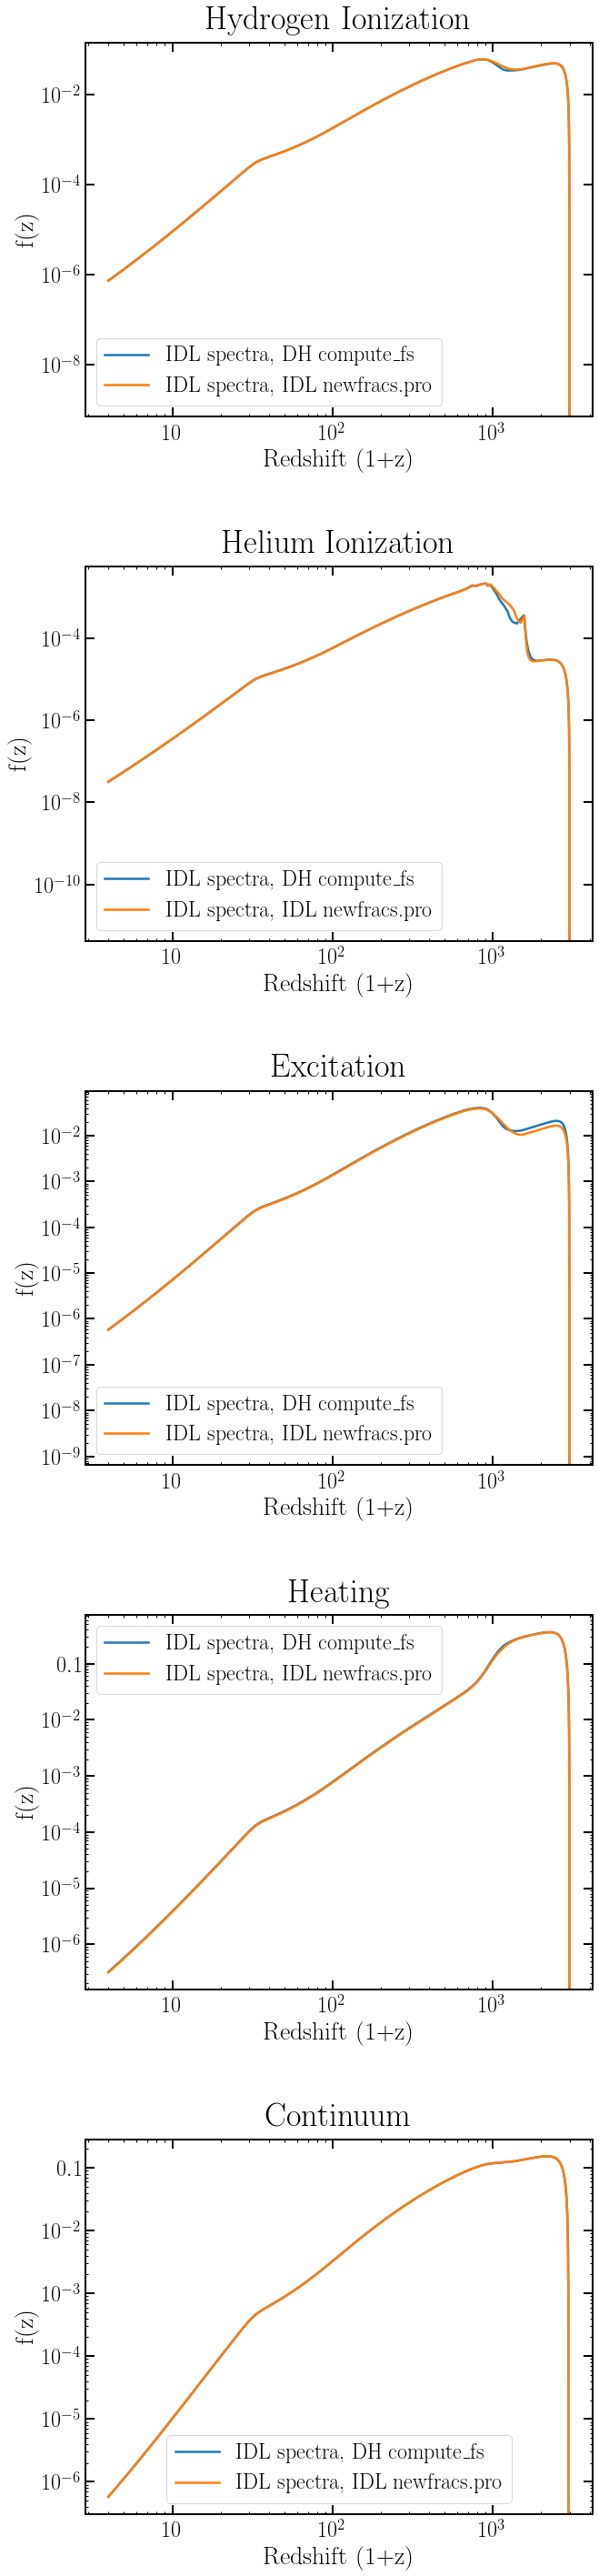

In [184]:
plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Redshift (1+z)')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec, f_arr_DH[:,i], label='IDL spectra, DH compute\_fs')
    plt.plot(rs_vec, f_idl[i,:], label='IDL spectra, IDL newfracs.pro')
    plt.legend()

## Comments

The agreement is excellent: slight deviations are expected because of the 1D vs. 2D interpolation we are doing over the MEDEA data.

# `main.evolve` Tests

### Spectrum Comparison

In [5]:
# pickle.dump(b_4e12, open("/Users/hongwan/Desktop/b_4e12.raw", "wb"))
b_4e12 = pickle.load(open("/Users/hongwan/Desktop/b_4e12.raw", "rb"))

[[1.03931104e-004 4.84606594e-010 5.55798424e-010]
 [1.12262993e-004 5.61861264e-010 6.44400358e-010]
 [1.21262829e-004 6.51115019e-010 7.46763091e-010]
 [1.30984159e-004 7.54151405e-010 8.64932434e-010]
 [1.41484823e-004 8.73001124e-010 1.00123710e-009]
 [1.52827298e-004 1.00997108e-009 1.15832230e-009]
 [1.65079070e-004 1.16766682e-009 1.33917562e-009]
 [1.78313035e-004 1.34904210e-009 1.54718522e-009]
 [1.92607933e-004 1.55742015e-009 1.78615994e-009]
 [2.08048817e-004 1.79652697e-009 2.06037642e-009]
 [2.24727556e-004 2.07054223e-009 2.37462407e-009]
 [2.42743387e-004 2.38412633e-009 2.73424775e-009]
 [2.62203501e-004 2.74244694e-009 3.14517264e-009]
 [2.83223683e-004 3.15120956e-009 3.61393946e-009]
 [3.05928998e-004 3.61670826e-009 4.14777050e-009]
 [3.30454541e-004 4.14580984e-009 4.75453881e-009]
 [3.56946233e-004 4.74592977e-009 5.44274259e-009]
 [3.85561696e-004 5.42511997e-009 6.22161631e-009]
 [4.16471187e-004 6.19195047e-009 7.10098193e-009]
 [4.49858613e-004 7.05540512e-0

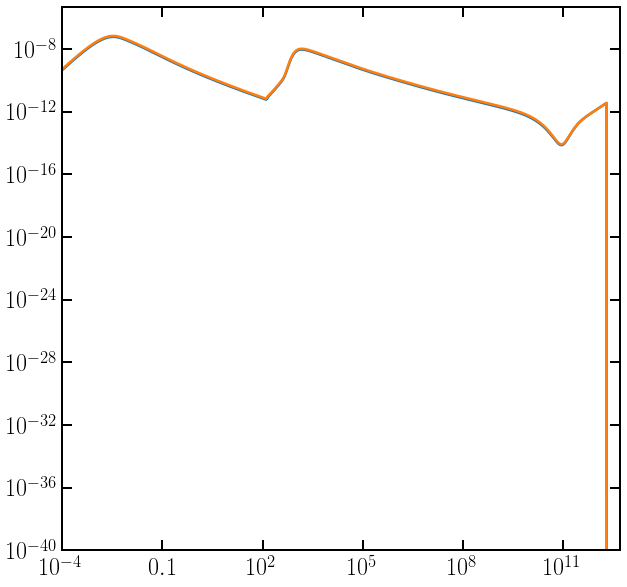

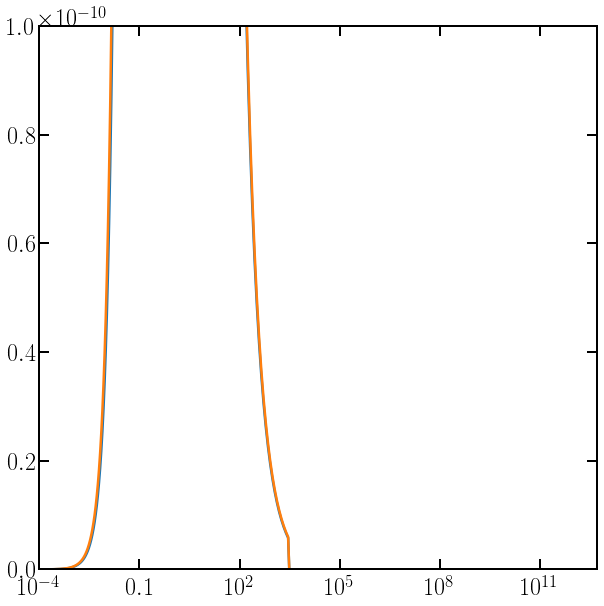

In [86]:
i = 6621

plt.figure()
ax = plt.gca()
# ax.set_xscale('log')
ax.loglog()

plt.axis([1e-4, 5e12, 1e-40, 5e-6])

photeng = idl_energy

plt.plot(photeng, b_4e12[2].grid_vals[i])
plt.plot(photeng, idl_photonspectrum[i]*idl_bin_width)

np.set_printoptions(threshold=np.nan)
utils.compare_arr([photeng, b_4e12[2][i].N, idl_photonspectrum[i]*idl_bin_width])

j = 200

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
# ax.loglog()

plt.axis([1e-4, 5e12, 1e-40, 1e-10])

photeng = idl_energy

plt.plot(photeng, b_4e12[3].grid_vals[j])
plt.plot(photeng, idl_lowengphot[j]*idl_bin_width)

### $f(z)$ Plots

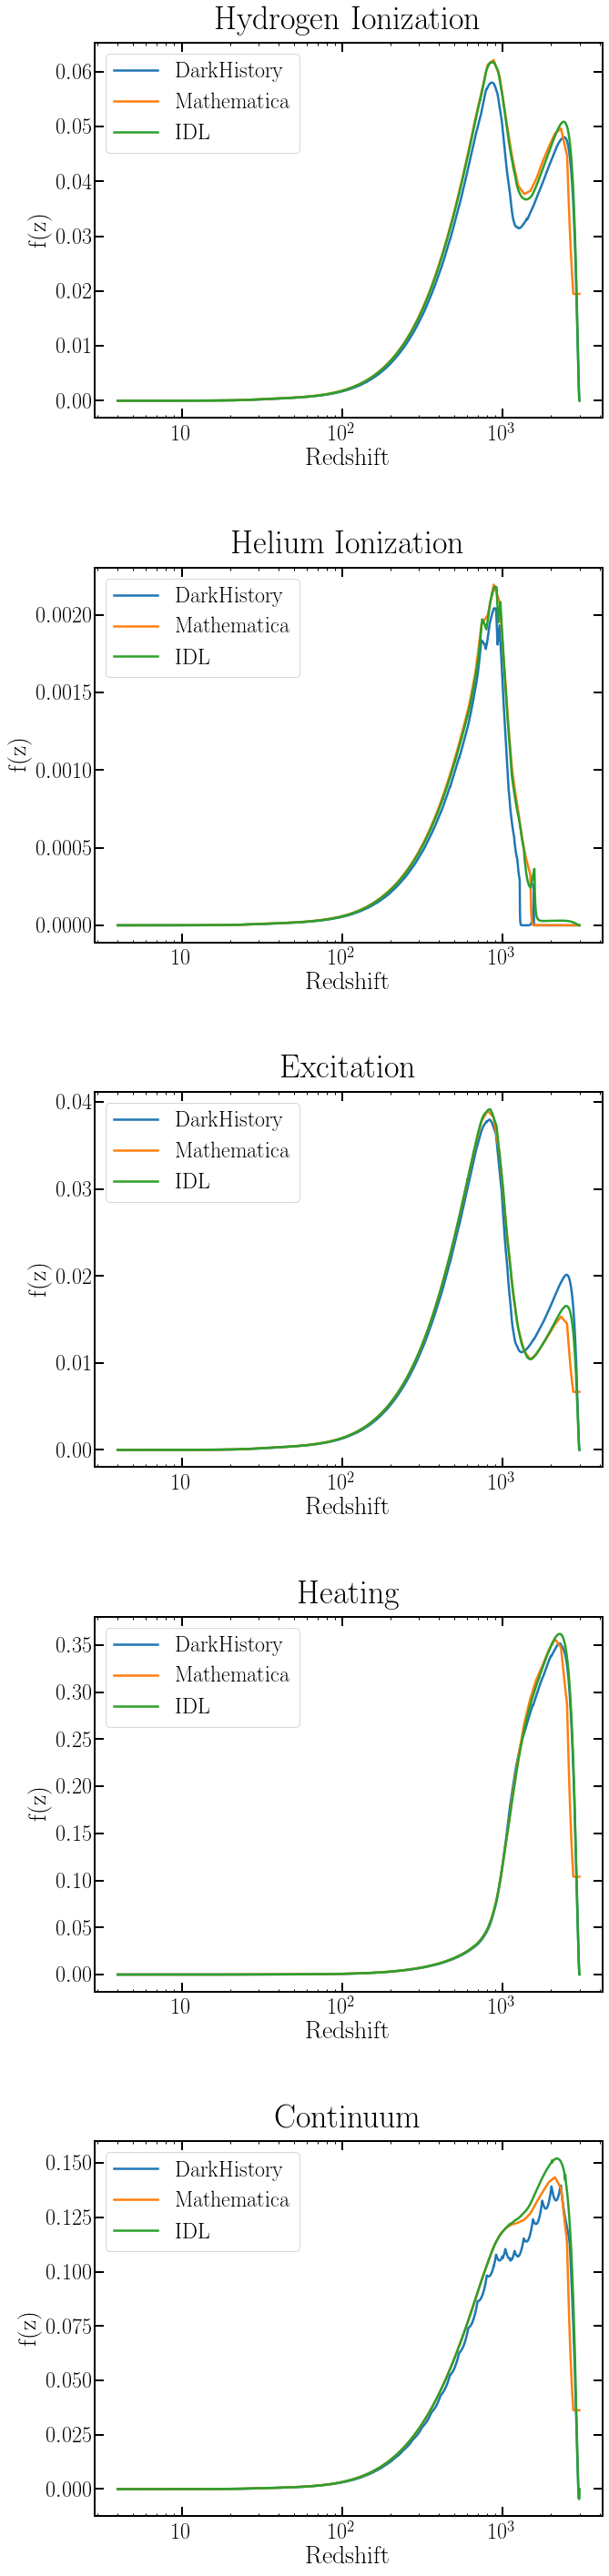

In [175]:
injE = photeng[photeng < mDM/2][-1]
    

f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec_math = np.vstack([
    f_H_ion_vec_math, f_He_ion_vec_math, 
    f_exc_vec_math, f_heat_vec_math, 
    f_cont_vec_math
])


plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec[1:], b_4e12[5][:,i], label='DarkHistory')
    plt.plot(rs_vec[1:], f_vec_math[i], label='Mathematica')
    plt.plot(rs_vec, f_idl[i], label='IDL')
    plt.legend()


## $m_\chi = 2 \times 10^{5}$ eV, $\chi \to \gamma \gamma$

### Evolution Cell

In [ ]:
eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

mDM = 2e5
tau = 3e25

# kinetic energy!
# elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - 2*phys.me)/2]), eleceng)
# elec_spec_init.rs = 3000

# phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

phot_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([mDM/2]), photeng)
phot_spec_init.rs = 3000

elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

b_2e5 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 4,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp, ics_only=False,
    ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf,
    coarsen_factor=1,std_soln=True, user=None, verbose=False, use_tqdm=True
)



### $f(z)$ Plots

In [ ]:


rs_vec = b_2e5[3].rs
injE = mDM/2
    

f_H_ion_vec   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec = np.vstack([f_H_ion_vec, f_He_ion_vec, f_exc_vec, f_heat_vec, f_cont_vec])

plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec[1:], b_2e5[5][:,i], label='DarkHistory')
    plt.plot(rs_vec[1:], f_vec[i], label='Mathematica')
    plt.legend()
